## Introduction
In this notebook we trained the 3D UNETR to segment primary lung tumors in CT scans

## Imports

* pathlib for easy path handling
* HTML for visualizing volume videos
* torchio for dataset creation
* torch for DataLoaders, optimizer and loss
* pytorch-lightning for training
* numpy for masking
* matplotlib for visualization
* Our 3D model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchio

!pip install pytorch-lightning
!pip install fvcore
!pip install thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=99c4fda4fa641976073eacdb625a824cf4a7a1e26732c6e8940e92967c5c227e
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/UPENN/CIS5810/my_project_train')
root_dir = '/content/drive/MyDrive/UPENN/CIS5810/my_project_train'

In [ ]:
from pathlib import Path

import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
from unetr import UNETR
from linear_unetr import Linear_UNETR

In [ ]:
import shutil
import os
from pathlib import Path

# 1. Define source (Drive) and destination (Local Fast Disk)
source_path = "/content/drive/MyDrive/UPENN/CIS5810/final_project/data/data_new"
local_path = "/content/local_data/data_new/"

# 2. Copy data
if not os.path.exists(local_path):
    print(f"Copying data from {source_path} to {local_path}...")
    shutil.copytree(source_path, local_path)
    print("Copy complete! Training will now be fast.")
else:
    print("Data already exists locally.")

# 3. Update BASE to point to the local fast data
BASE = Path(local_path)

Copying data from /content/drive/MyDrive/UPENN/CIS5810/final_project/data/data_new to /content/local_data/data_new/...
Copy complete! Training will now be fast.


In [ ]:
import torch
vram = torch.cuda.get_device_properties(0).total_memory / (1024**3)
print(f"GPU Model: {torch.cuda.get_device_name(0)}")
print(f"Total GPU VRAM: {vram:.2f} GB")

GPU Model: NVIDIA A100-SXM4-80GB
Total GPU VRAM: 79.32 GB


## Dataset Creation
We can loop over all available scans and add them to the subject list

In [ ]:
from pathlib import Path
import torchio as tio

# --- Base split root ---
BASE = Path("/content/local_data/data_new")

def change_img_to_label_path(p: Path) -> Path:
    """
    Map:
      .../image/Lung_xxx_0000.nii.gz  -->  .../label_gtvp/Lung_xxx.nii.gz
    """
    if p.parent.name != "image":
        raise ValueError(f"Expected parent folder named 'image', got: {p.parent}")
    label_dir = p.parent.with_name("label_gtvp")
    name = p.name
    if name.endswith("_0000.nii.gz"):
        name = name[:-len("_0000.nii.gz")] + ".nii.gz"
    else:
        name = name.replace("_0000", "")
        if not name.endswith(".nii.gz"):
            name += ".nii.gz"
    return label_dir / name

In [ ]:
from pathlib import Path
import torchio as tio

# --- Base split root ---
BASE = Path("/content/local_data/data_new")
SPLITS_ROOT = BASE / "train"      # contains fold0, fold1, ...

def change_img_to_label_path(p: Path) -> Path:
    """
    Map:
      .../image/Lung_xxx_0000.nii.gz  -->  .../label_gtvp/Lung_xxx.nii.gz
    """
    if p.parent.name != "image":
        raise ValueError(f"Expected parent folder named 'image', got: {p.parent}")
    label_dir = p.parent.with_name("label_gtvp")
    name = p.name
    if name.endswith("_0000.nii.gz"):
        name = name[:-len("_0000.nii.gz")] + ".nii.gz"
    else:
        name = name.replace("_0000", "")
        if not name.endswith(".nii.gz"):
            name += ".nii.gz"
    return label_dir / name


def build_subjects(split_dir: Path, require_label: bool = True):
    """
    Create TorchIO subjects from a split directory (train/val).
    """
    image_paths = sorted(split_dir.rglob(r"image/Lung_*_0000.nii.gz"))
    subjects, missing = [], 0

    for img_path in image_paths:
        lab_path = change_img_to_label_path(img_path)
        if lab_path.exists():
            subjects.append(
                tio.Subject(
                    CT=tio.ScalarImage(img_path),
                    Label=tio.LabelMap(lab_path),
                )
            )
        else:
            missing += 1
            if require_label:
                print(f"[WARN] Missing label for: {img_path.name} -> {lab_path.name}")
                continue
            subjects.append(tio.Subject(CT=tio.ScalarImage(img_path)))

    print(f"[{split_dir}] Built {len(subjects)} subjects (missing labels: {missing})")
    return subjects


# ---------- Helpers for 5-fold CV ----------

NUM_FOLDS = 1

def load_fold(fold_idx: int):
    """
    Return (train_subjects, val_subjects) for a given fold index.
    Expects:
      .../splits/train/fold{fold_idx}/train
      .../splits/train/fold{fold_idx}/val
    """
    fold_dir = SPLITS_ROOT / f"fold{fold_idx}"
    train_dir = fold_dir / "train"
    val_dir   = fold_dir / "val"

    train_subj = build_subjects(train_dir, require_label=True)
    val_subj   = build_subjects(val_dir,   require_label=True)
    return train_subj, val_subj


# # Example: load a single fold (e.g., fold 0)
# fold_idx = 0
# train_subjects, val_subjects = load_fold(fold_idx)

test_subjects  = build_subjects(BASE  / "test",  require_label=True)  # flip to True if you do have test labels

# Or, if you want to pre-load all folds:
all_folds = {}
for k in range(NUM_FOLDS):
    tr, va = load_fold(k)
    all_folds[k] = {"train": tr, "val": va}
    print(f"Fold {k}: train={len(tr)}, val={len(va)}")

[/content/local_data/data_new/test] Built 40 subjects (missing labels: 0)
[/content/local_data/data_new/train/fold0/train] Built 88 subjects (missing labels: 0)
[/content/local_data/data_new/train/fold0/val] Built 22 subjects (missing labels: 0)
Fold 0: train=88, val=22


In [ ]:
for subject in test_subjects:
    assert subject["CT"].orientation == ("L", "P", "S")

We use the same  augmentation steps as used in the Dataset notebook. <br />
Regarding the processing, we use the **CropOrPad** functionality which crops or pads all images and masks to the same shape. <br />

We use ($256 \times 256 \times 200$)

In [ ]:
import torch
import torchio as tio
import pytorch_lightning as pl
import numpy as np
import random

# ---- top-level, picklable transforms ----
class ScaleCT3071_NoClamp(tio.transforms.IntensityTransform):
    """Divide CT intensities by 3071 in-place (keeps negatives and >1 values)."""
    def apply_transform(self, subject: tio.Subject) -> tio.Subject:
        if 'CT' in subject and isinstance(subject['CT'], tio.ScalarImage):
            data = subject['CT'].data
            if not torch.is_floating_point(data):
                data = data.float()
            subject['CT'].set_data(data / 3071.0)
        return subject


class RemapLabelToBinary(tio.transforms.Transform):
    def apply_transform(self, subject: tio.Subject) -> tio.Subject:
        if 'Label' in subject:
            lab = subject['Label'].data
            subject['Label'].set_data((lab > 0).to(torch.uint8))
        return subject

# ---- processing & augmentation ----
process = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(target=(1.5, 1.5, 2.0)),
    tio.CropOrPad((256, 256, 200)),
    RemapLabelToBinary(),
    ScaleCT3071_NoClamp(),
])

augmentation = tio.RandomAffine(
    scales=(0.9, 1.1),
    degrees=(-10, 10),
    image_interpolation='linear',
    label_interpolation='nearest',
)

val_transform = process
test_transform = process
train_transform = tio.Compose([process, augmentation])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchio as tio

class SoftDiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, logits, target):
        # logits, target: (B,1,H,W,D)
        prob = torch.sigmoid(logits)
        num  = 2 * (prob * target).sum(dim=(1,2,3,4)) + self.eps
        den  = (prob.pow(2) + target.pow(2)).sum(dim=(1,2,3,4)) + self.eps
        return 1.0 - (num / den).mean()

class Segmenter(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,         # e.g., UNet()
        lr: float = 1e-4,
        ce_weights=None,          # (w_bg, w_tumor) if model outputs 2 classes
        bce_pos_weight=None,      # e.g., 4.0 to upweight positives for 1-channel output
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        self.lr = lr

        # Optional class weights as buffers (travel with device)
        self.register_buffer(
            "ce_weights_buf",
            torch.tensor(ce_weights, dtype=torch.float32) if ce_weights is not None else None
        )
        self.register_buffer(
            "bce_pos_weight_buf",
            torch.tensor([float(bce_pos_weight)], dtype=torch.float32) if bce_pos_weight is not None else None
        )
        self.soft_dice = SoftDiceLoss()

    def forward(self, x):
        return self.model(x)   # logits: (B,C,H,W,D) or (B,1,H,W,D)

    @staticmethod
    def _hard_dice_binary(pred_bin: torch.Tensor, gt_bin: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        # pred_bin, gt_bin: (B,1,H,W,D) or (B,1,H,W)
        pred_bin = pred_bin.bool()
        gt_bin   = gt_bin.bool()
        reduce_dims = list(range(1, pred_bin.ndim))
        inter = (pred_bin & gt_bin).sum(dim=reduce_dims)
        denom = pred_bin.sum(dim=reduce_dims) + gt_bin.sum(dim=reduce_dims)
        return ((2 * inter + eps) / (denom + eps)).mean()

    def _shared_step(self, batch, stage: str):
        x = batch["CT"][tio.DATA]          # (B,1,H,W,D)
        y = batch["Label"][tio.DATA]       # (B,1,H,W,D), tumor > 0

        logits = self(x)                   # (B,C,H,W,D) or (B,1,H,W,D)
        C = logits.shape[1]

        if C == 1:
            # ----- Binary branch (BCE with logits) -----
            target = (y > 0).float()                         # (B,1,H,W,D)
            # Functional API lets us pass pos_weight easily
            bce = F.binary_cross_entropy_with_logits(
                logits, target, pos_weight=self.bce_pos_weight_buf
            )
            dsc = self.soft_dice(logits, target)
            loss = bce + dsc                      # <-- combined loss

            pred_bin = (torch.sigmoid(logits) > 0.5)         # (B,1,H,W,D)
            gt_bin   = (y > 0)
        else:
            # ----- Multiclass branch (CE; assume tumor is class 1) -----
            target = (y[:, 0] > 0).long()                    # (B,H,W,D)
            loss = F.cross_entropy(logits, target, weight=self.ce_weights_buf)
            pred_bin = (logits.argmax(dim=1, keepdim=True) == 1)  # (B,1,H,W,D)
            gt_bin   = (target == 1).unsqueeze(1)

        dice = self._hard_dice_binary(pred_bin, gt_bin)

        B = x.shape[0]

        # Log loss: training step & epoch; validation epoch
        self.log(f"{stage}_loss", loss,
                 on_step=(stage == "train"), on_epoch=True, prog_bar=True, batch_size=B)

        # Log dice: **train on_step + on_epoch** (so live curve shows), val on_epoch
        self.log(f"{stage}_dice", dice,
                 on_step=(stage == "train"), on_epoch=True, prog_bar=True, batch_size=B)

        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
# ---- Live per-patient Dice (training + validation) ----
import numpy as np
import torch
import torchio as tio
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import pytorch_lightning as pl
from typing import Optional

# ---------- full-volume prediction ----------
@torch.no_grad()
def predict_full_volume_tio(
    subject: tio.Subject,
    model: torch.nn.Module,
    device: Optional[torch.device] = None,
    patch_size=(96, 96, 96),
    patch_overlap=(32, 32, 32),
    batch_size=2,
    num_workers=0,
    overlap_mode='average',
    tumor_idx: int = 1,   # kept for completeness; channel 1 = tumor
) -> torch.Tensor:
    """
    Sliding-window inference with TorchIO GridSampler/Aggregator.
    Returns **2-channel probability** tensor [2, W, H, D] (bg, tumor).
    """
    model.eval()
    if device is None:
        device = getattr(model, 'device', None) or next(model.parameters()).device

    sampler = tio.inference.GridSampler(subject, patch_size=patch_size, patch_overlap=patch_overlap)
    aggregator = tio.inference.GridAggregator(sampler, overlap_mode=overlap_mode)

    loader = torch.utils.data.DataLoader(
        sampler, batch_size=batch_size, num_workers=num_workers,
        , persistent_workers=(num_workers > 0)
    )

    for batch in loader:
        x = batch['CT'][tio.DATA].to(device)      # [B,1,w,h,d]
        logits = model(x)                          # [B,C,w,h,d], want C=2

        if logits.shape[1] == 1:
            # upgrade 1-channel (sigmoid) -> 2-channel probs for consistency
            prob_fg = torch.sigmoid(logits[:, 0:1])       # [B,1,w,h,d]
            prob_bg = 1.0 - prob_fg
            probs = torch.cat([prob_bg, prob_fg], dim=1)  # [B,2,w,h,d]
        else:
            probs = torch.softmax(logits, dim=1)          # [B,2,w,h,d]

        aggregator.add_batch(probs.detach().cpu(), batch[tio.LOCATION])

    return aggregator.get_output_tensor()                 # [2, W, H, D]


def logits_to_binary_pred(logits_chwhd: torch.Tensor, tumor_idx=1, pos_thresh=0.5) -> np.ndarray:
    """[C,W,H,D] -> uint8 [W,H,D]"""
    C = logits_chwhd.shape[0]
    if C == 1:
        prob = torch.sigmoid(logits_chwhd[0])
        pred = (prob > pos_thresh)
    else:
        pred = (torch.argmax(logits_chwhd, dim=0) == tumor_idx)
    return pred.numpy().astype(np.uint8)

def subject_label_binary(subject: tio.Subject, tumor_positive_values=(1,)) -> np.ndarray:
    """TorchIO label -> uint8 [W,H,D]"""
    lab = subject['Label'][tio.DATA][0].detach().cpu().numpy()
    return np.isin(lab, tumor_positive_values).astype(np.uint8)

def dice_binary(y_true: np.ndarray, y_pred: np.ndarray, eps=1e-6, empty_ok_as=1.0) -> float:
    y_true = (y_true > 0).astype(np.uint8)
    y_pred = (y_pred > 0).astype(np.uint8)
    t, p = y_true.sum(), y_pred.sum()
    if t == 0 and p == 0:
        return float(empty_ok_as)
    inter = (y_true & y_pred).sum()
    return float((2 * inter + eps) / (t + p + eps))

def get_subject_id(subj: tio.Subject, fallback_prefix="case"):
    """
    Prefer CT filename; strip '_0000' so 'Lung_123_0000.nii.gz' -> 'Lung_123'.
    Falls back to subject['subject_id'] or a generic name.
    """
    try:
        p = Path(subj['CT'].path)
        stem = p.stem  # e.g., Lung_123_0000
        return stem.replace('_0000', '')
    except Exception:
        sid = subj.get('subject_id', None)
        return str(sid) if sid is not None else fallback_prefix

In [ ]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pytorch_lightning as pl

class LiveEpochCurves(pl.callbacks.Callback):
    def __init__(
        self,
        title="3D UNETR",
        save_dir=None,
        base_filename="curves",
        save_each_epoch=True,
        show_inline=True,
    ):
        super().__init__()
        self.title = title
        self.save_dir = Path(save_dir) if save_dir is not None else None
        self.base_filename = base_filename
        self.save_each_epoch = save_each_epoch
        self.show_inline = show_inline

        self.history = {
            "epoch":      [],
            "train_loss": [],
            "val_loss":   [],
            "train_dice": [],
            "val_dice":   [],
        }

        # for updating the same output cell instead of stacking many figures
        self._display_handle = None

    def _get_metric(self, metrics, name):
        v = metrics.get(name)
        if v is None:
            return None
        try:
            return float(v)
        except Exception:
            return None

    # ---------- save two separate PNGs (loss + dice) ----------
    def _save_pngs(self):
        if self.save_dir is None or self.base_filename is None:
            return
        epochs = self.history["epoch"]
        if len(epochs) == 0:
            return

        self.save_dir.mkdir(parents=True, exist_ok=True)

        # Loss
        fig_loss, ax = plt.subplots(figsize=(6, 4))
        fig_loss.suptitle(f"{self.title} — Loss")
        ax.plot(epochs, self.history["train_loss"], label="train_loss")
        ax.plot(epochs, self.history["val_loss"], "o-", label="val_loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True, alpha=0.3)
        loss_path = self.save_dir / f"{self.base_filename}_loss.png"
        fig_loss.savefig(loss_path, dpi=150)
        plt.close(fig_loss)

        # Dice
        fig_dice, ax = plt.subplots(figsize=(6, 4))
        fig_dice.suptitle(f"{self.title} — Dice")
        ax.plot(epochs, self.history["train_dice"], label="train_dice")
        ax.plot(epochs, self.history["val_dice"], "o-", label="val_dice")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Dice")
        ax.legend()
        ax.grid(True, alpha=0.3)
        dice_path = self.save_dir / f"{self.base_filename}_dice.png"
        fig_dice.savefig(dice_path, dpi=150)
        plt.close(fig_dice)

    # ---------- inline display: single combined figure (updated each epoch) ----------
    def _show_inline_combined(self):
        if not self.show_inline:
            return

        epochs = self.history["epoch"]
        if len(epochs) == 0:
            return

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(self.title)

        # Loss subplot
        ax = axes[0]
        ax.plot(epochs, self.history["train_loss"], label="train_loss")
        ax.plot(epochs, self.history["val_loss"], "o-", label="val_loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Dice subplot
        ax = axes[1]
        ax.plot(epochs, self.history["train_dice"], label="train_dice")
        ax.plot(epochs, self.history["val_dice"], "o-", label="val_dice")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Dice")
        ax.legend()
        ax.grid(True, alpha=0.3)

        try:
            from IPython.display import display
        except ImportError:
            plt.close(fig)
            return

        if self._display_handle is None:
            self._display_handle = display(fig, display_id=True)
        else:
            self._display_handle.update(fig)

        plt.close(fig)

    def _update_plots(self):
        self._save_pngs()
        self._show_inline_combined()

    # ---------- Lightning hooks ----------
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch

        self.history["epoch"].append(epoch)
        self.history["train_loss"].append(self._get_metric(metrics, "train_loss"))
        self.history["val_loss"].append(self._get_metric(metrics, "val_loss"))
        self.history["train_dice"].append(self._get_metric(metrics, "train_dice"))
        self.history["val_dice"].append(self._get_metric(metrics, "val_dice"))

        if self.save_each_epoch:
            self._update_plots()

    def on_fit_end(self, trainer, pl_module):
        if not self.save_each_epoch:
            self._update_plots()


Define the train and validation dataset. We use 88 subjects for training and 22 for validation. <br />
In order to help the segmentation network learn, we use the LabelSampler with p=0.2 for background, p=0.8 for lung tumors with a patch size of ($96 \times 96 \times 64$).

In [ ]:
import torch
import torchio as tio
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

#----------------------------
# global options / samplers
# ----------------------------
use_amp = True
train_bs = 4 if use_amp else 2
val_bs   = min(8, 2 * train_bs)

# same samplers for every fold
train_sampler = tio.data.LabelSampler(
    patch_size=(96, 96, 96),
    label_name="Label",
    label_probabilities={0: 0.2, 1: 0.8},
)
val_sampler = tio.data.UniformSampler(
    patch_size=(96, 96, 96),
)

use_gpu = torch.cuda.is_available()

try:
    from pytorch_lightning.callbacks import TQDMProgressBar
except Exception:
    from lightning.pytorch.callbacks import TQDMProgressBar

Finally we can create the Segmentation model.

We use the Adam optimizer with a learning rate of 1e-4 and a weighted cross-entropy loss, which assigns a threefold increased loss to tumorous voxels.

In [ ]:
import pandas as pd
from fvcore.nn import FlopCountAnalysis, flop_count_table
import time
import torch
import pytorch_lightning as pl
from thop import profile
from pathlib import Path

class PerformanceMonitor(pl.Callback):
    """
    Measures training performance metrics: batch latency, FLOPs, peak memory usage, and epoch duration.
    Stores results and saves them to a CSV file at the end of training.
    """
    def __init__(self, output_path=None):
        self.batch_times = []
        self.peak_memory_bytes = []
        self.forward_flops = None
        self.estimated_flops_per_batch = None # For a single forward pass, scaled by batch size
        self.total_training_flops_per_epoch = 0
        self.warmup_batches = 5 # Skip first few batches for latency calculation
        self.metrics_history = [] # To store metrics for all epochs
        self.output_path = Path(output_path) if output_path else None
        self.epoch_start_time = 0.0

    def on_train_start(self, trainer, pl_module):
        # Determine device for dummy input
        device = pl_module.device
        if trainer.strategy.accelerator.name == 'cuda':
            torch.cuda.reset_peak_memory_stats(device)

        # Create a dummy input to calculate FLOPs.
        # The patch_size used for DataLoader is (96, 96, 96)
        dummy_input = torch.randn(1, 1, 96, 96, 96).to(device)

        try:
            # Calculate FLOPs for a single forward pass using thop.profile
            macs, params = profile(pl_module.model, inputs=(dummy_input,), verbose=False)
            # FLOPs = 2 * MACs (Multiply-Accumulate operations)
            self.forward_flops = macs * 2

            # Log FLOPs for the initial forward pass
            trainer.logger.log_metrics({"forward_flops": self.forward_flops}, step=0)
        except Exception as e:
            print(f"⚠️ FLOPs calculation skipped: {e}")
            self.forward_flops = 0

        # Estimate FLOPs for an actual training batch (forward + backward)
        # A common heuristic is that backward pass is ~2x forward pass FLOPs, so total training is ~3x forward.
        current_batch_size = trainer.train_dataloader.batch_size if trainer.train_dataloader else 1
        if self.forward_flops:
            self.estimated_flops_per_batch = self.forward_flops * current_batch_size * 3 # 3x for training (forward + backward)
        else:
            self.estimated_flops_per_batch = 0

        self.batch_times = []
        self.peak_memory_bytes = []
        self.total_training_flops_per_epoch = 0
        self.metrics_history = [] # Reset history for a new training run (e.g., new fold)

    def on_train_epoch_start(self, trainer, pl_module):
        self.epoch_start_time = time.time()

    def on_train_batch_start(self, trainer, pl_module, batch, batch_idx):
        self.batch_start_time = time.time()
        if torch.cuda.is_available() and pl_module.device.type == 'cuda':
            torch.cuda.reset_peak_memory_stats(pl_module.device)

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        batch_duration = time.time() - self.batch_start_time
        self.batch_times.append(batch_duration)

        if torch.cuda.is_available() and pl_module.device.type == 'cuda':
            mem_allocated = torch.cuda.max_memory_allocated(pl_module.device)
            self.peak_memory_bytes.append(mem_allocated)

        # Accumulate estimated training FLOPs for the epoch
        if self.estimated_flops_per_batch:
            # Access the tensor data within the 'CT' dictionary
            current_batch_size = 1
            if isinstance(batch, dict) and 'CT' in batch:
                 if isinstance(batch['CT'], dict) and 'data' in batch['CT']:
                     current_batch_size = batch['CT']['data'].shape[0]
                 elif hasattr(batch['CT'], 'data'): # TorchIO object
                     current_batch_size = batch['CT'].data.shape[0]

            self.total_training_flops_per_epoch += self.forward_flops * current_batch_size * 3

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_duration = time.time() - self.epoch_start_time

        epoch_metrics = {
            "epoch": trainer.current_epoch,
            "epoch_duration_sec": epoch_duration,
            "avg_batch_latency_sec": None,
            "max_peak_memory_bytes": None,
            "max_peak_memory_mb": None,
            "total_training_flops_per_epoch": None,
        }

        # Log duration
        trainer.logger.log_metrics({"epoch_duration_sec": epoch_duration}, step=trainer.current_epoch)

        # Log aggregated metrics at the end of the epoch
        if self.batch_times:
            avg_batch_latency = self._get_avg_batch_latency_sec()
            if avg_batch_latency is not None:
                trainer.logger.log_metrics({"avg_batch_latency_sec": avg_batch_latency}, step=trainer.current_epoch)
                epoch_metrics["avg_batch_latency_sec"] = avg_batch_latency
            # Reset for next epoch
            self.batch_times = []

        if self.peak_memory_bytes:
            max_peak_memory_bytes = max(self.peak_memory_bytes)
            max_peak_memory_mb = max_peak_memory_bytes / (1024 * 1024)
            trainer.logger.log_metrics({"max_peak_memory_bytes": float(max_peak_memory_bytes), "max_peak_memory_mb": max_peak_memory_mb}, step=trainer.current_epoch)
            epoch_metrics["max_peak_memory_bytes"] = max_peak_memory_bytes
            epoch_metrics["max_peak_memory_mb"] = max_peak_memory_mb
            # Reset for next epoch
            self.peak_memory_bytes = []

        if self.total_training_flops_per_epoch:
            trainer.logger.log_metrics({"total_training_flops_per_epoch": float(self.total_training_flops_per_epoch)}, step=trainer.current_epoch)
            epoch_metrics["total_training_flops_per_epoch"] = self.total_training_flops_per_epoch
            # Reset for next epoch
            self.total_training_flops_per_epoch = 0

        print(f"EPOCH_METRICS: {epoch_metrics}")
        self.metrics_history.append(epoch_metrics)

    def on_train_end(self, trainer, pl_module):
        if self.output_path and self.metrics_history:
            self.output_path.parent.mkdir(parents=True, exist_ok=True)
            df_metrics = pd.DataFrame(self.metrics_history)
            df_metrics.to_csv(self.output_path, index=False)
            print(f"Performance metrics saved to: {self.output_path}")

    def _get_avg_batch_latency_sec(self):
        if len(self.batch_times) > self.warmup_batches:
            return sum(self.batch_times[self.warmup_batches:]) / (len(self.batch_times) - self.warmup_batches)
        elif self.batch_times:
            return sum(self.batch_times) / len(self.batch_times)
        return None

In [ ]:
import torch
import torchio as tio
from torch.utils.data import DataLoader, default_collate
import pytorch_lightning as pl
# --- Define the custom collate function ---
def collate_tio(batch):
    """
    Converts TorchIO Subjects/Images into plain Python dictionaries
    before batching. This prevents PyTorch from trying to reconstruct
    ScalarImage objects, which causes the TypeError.
    """
    def unwrap(obj):
        # If it's a TorchIO object (Subject or Image), turn it into a dict
        if isinstance(obj, (tio.Subject, tio.Image)):
            return {k: unwrap(v) for k, v in obj.items()}
        return obj

    # Unwrap the batch elements and then use PyTorch's default collation
    unwrapped_batch = [unwrap(x) for x in batch]
    return default_collate(unwrapped_batch)

INFO:lightning_fabric.utilities.seed:Seed set to 1337



========== FOLD fold0 ==========

[/content/local_data/data_new/train/fold0/train] Built 88 subjects (missing labels: 0)
[/content/local_data/data_new/train/fold0/val] Built 22 subjects (missing labels: 0)


/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggere

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type         ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ Linear_UNETR │  146 M │ train │     0 │
│ 1 │ soft_dice │ SoftDiceLoss │      0 │ train │     0 │
└───┴───────────┴──────────────┴────────┴───────┴───────┘

Trainable params: 146 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 146 M                                                                                                
Total estimated model params size (MB): 586                                                                        
Modules in train mode: 331                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

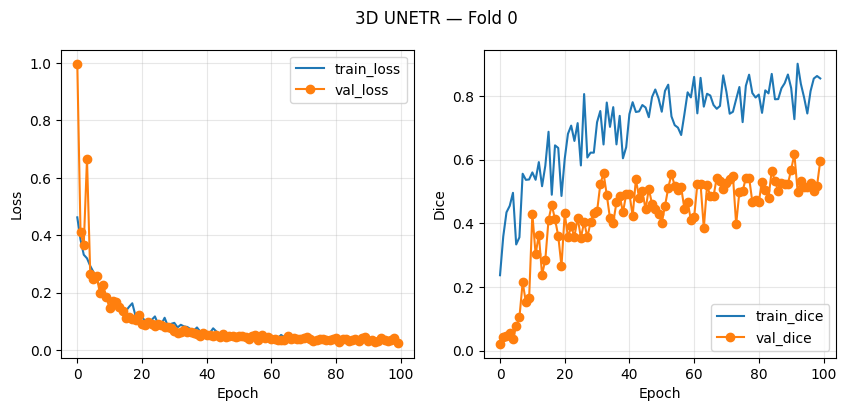

EPOCH_METRICS: {'epoch': 0, 'epoch_duration_sec': 255.4384331703186, 'avg_batch_latency_sec': 4.927126912509694, 'max_peak_memory_bytes': 57667730944, 'max_peak_memory_mb': 54996.23388671875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 1, 'epoch_duration_sec': 194.93223214149475, 'avg_batch_latency_sec': 4.934046394684735, 'max_peak_memory_bytes': 57670746624, 'max_peak_memory_mb': 54999.10986328125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 2, 'epoch_duration_sec': 169.6003019809723, 'avg_batch_latency_sec': 4.939603903714349, 'max_peak_memory_bytes': 57670747648, 'max_peak_memory_mb': 54999.11083984375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 3, 'epoch_duration_sec': 185.366628408432, 'avg_batch_latency_sec': 4.94561432389652, 'max_peak_memory_bytes': 57670748672, 'max_peak_memory_mb': 54999.11181640625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 4, 'epoch_duration_sec': 178.04511165618896, 'avg_batch_latency_sec': 4.917794816634235, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 5, 'epoch_duration_sec': 226.91200184822083, 'avg_batch_latency_sec': 4.953903647030101, 'max_peak_memory_bytes': 57670750208, 'max_peak_memory_mb': 54999.11328125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 6, 'epoch_duration_sec': 160.08348894119263, 'avg_batch_latency_sec': 4.927651208989761, 'max_peak_memory_bytes': 57670751232, 'max_peak_memory_mb': 54999.1142578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 7, 'epoch_duration_sec': 187.34539437294006, 'avg_batch_latency_sec': 4.950275729684269, 'max_peak_memory_bytes': 57670752256, 'max_peak_memory_mb': 54999.115234375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 8, 'epoch_duration_sec': 216.68074345588684, 'avg_batch_latency_sec': 4.917613127652337, 'max_peak_memory_bytes': 57670753280, 'max_peak_memory_mb': 54999.1162109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 9, 'epoch_duration_sec': 204.15588402748108, 'avg_batch_latency_sec': 4.9894696964937095, 'max_peak_memory_bytes': 57670754304, 'max_peak_memory_mb': 54999.1171875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 10, 'epoch_duration_sec': 146.10398721694946, 'avg_batch_latency_sec': 4.947886761497049, 'max_peak_memory_bytes': 57670755328, 'max_peak_memory_mb': 54999.1181640625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 11, 'epoch_duration_sec': 201.57871389389038, 'avg_batch_latency_sec': 4.923899005441105, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 12, 'epoch_duration_sec': 194.77182507514954, 'avg_batch_latency_sec': 4.931469763026518, 'max_peak_memory_bytes': 57670757376, 'max_peak_memory_mb': 54999.1201171875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 13, 'epoch_duration_sec': 206.71234226226807, 'avg_batch_latency_sec': 4.91528795747196, 'max_peak_memory_bytes': 57670758400, 'max_peak_memory_mb': 54999.12109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 14, 'epoch_duration_sec': 212.0219600200653, 'avg_batch_latency_sec': 4.971661735983456, 'max_peak_memory_bytes': 57670758912, 'max_peak_memory_mb': 54999.12158203125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 15, 'epoch_duration_sec': 148.96819400787354, 'avg_batch_latency_sec': 4.928741118487189, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 16, 'epoch_duration_sec': 188.28600692749023, 'avg_batch_latency_sec': 4.936148096533382, 'max_peak_memory_bytes': 57670750720, 'max_peak_memory_mb': 54999.11376953125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 17, 'epoch_duration_sec': 191.6616439819336, 'avg_batch_latency_sec': 4.922317056094899, 'max_peak_memory_bytes': 57670751744, 'max_peak_memory_mb': 54999.11474609375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 18, 'epoch_duration_sec': 232.23937821388245, 'avg_batch_latency_sec': 4.95983801168554, 'max_peak_memory_bytes': 57670752256, 'max_peak_memory_mb': 54999.115234375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 19, 'epoch_duration_sec': 140.24479627609253, 'avg_batch_latency_sec': 5.000072549371159, 'max_peak_memory_bytes': 57670752768, 'max_peak_memory_mb': 54999.11572265625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 20, 'epoch_duration_sec': 177.1019787788391, 'avg_batch_latency_sec': 4.944166071274701, 'max_peak_memory_bytes': 57670753280, 'max_peak_memory_mb': 54999.1162109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 21, 'epoch_duration_sec': 142.10194420814514, 'avg_batch_latency_sec': 4.958391792633954, 'max_peak_memory_bytes': 57670754304, 'max_peak_memory_mb': 54999.1171875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 22, 'epoch_duration_sec': 236.49043655395508, 'avg_batch_latency_sec': 4.9486148637883804, 'max_peak_memory_bytes': 57670754816, 'max_peak_memory_mb': 54999.11767578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 23, 'epoch_duration_sec': 185.27259397506714, 'avg_batch_latency_sec': 4.935911052367267, 'max_peak_memory_bytes': 57670755328, 'max_peak_memory_mb': 54999.1181640625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 24, 'epoch_duration_sec': 167.52758884429932, 'avg_batch_latency_sec': 4.97754820655374, 'max_peak_memory_bytes': 57670755840, 'max_peak_memory_mb': 54999.11865234375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 25, 'epoch_duration_sec': 184.0718069076538, 'avg_batch_latency_sec': 4.940273242838242, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 26, 'epoch_duration_sec': 180.8434145450592, 'avg_batch_latency_sec': 4.915071599623737, 'max_peak_memory_bytes': 57670756864, 'max_peak_memory_mb': 54999.11962890625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 27, 'epoch_duration_sec': 248.51138162612915, 'avg_batch_latency_sec': 4.921494357726154, 'max_peak_memory_bytes': 57670757376, 'max_peak_memory_mb': 54999.1201171875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 28, 'epoch_duration_sec': 171.1295657157898, 'avg_batch_latency_sec': 4.930418968200684, 'max_peak_memory_bytes': 57670757888, 'max_peak_memory_mb': 54999.12060546875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 29, 'epoch_duration_sec': 182.1891689300537, 'avg_batch_latency_sec': 4.938881018582513, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 30, 'epoch_duration_sec': 199.14109444618225, 'avg_batch_latency_sec': 4.919661101172952, 'max_peak_memory_bytes': 57670750720, 'max_peak_memory_mb': 54999.11376953125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 31, 'epoch_duration_sec': 233.57978677749634, 'avg_batch_latency_sec': 4.922474061741548, 'max_peak_memory_bytes': 57670751744, 'max_peak_memory_mb': 54999.11474609375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 32, 'epoch_duration_sec': 149.1018636226654, 'avg_batch_latency_sec': 4.938166758593391, 'max_peak_memory_bytes': 57670752768, 'max_peak_memory_mb': 54999.11572265625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 33, 'epoch_duration_sec': 199.07912826538086, 'avg_batch_latency_sec': 4.929676841287052, 'max_peak_memory_bytes': 57670753280, 'max_peak_memory_mb': 54999.1162109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 34, 'epoch_duration_sec': 186.63818740844727, 'avg_batch_latency_sec': 4.937038674074061, 'max_peak_memory_bytes': 57670754304, 'max_peak_memory_mb': 54999.1171875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 35, 'epoch_duration_sec': 197.83841252326965, 'avg_batch_latency_sec': 4.913258117787978, 'max_peak_memory_bytes': 57670754816, 'max_peak_memory_mb': 54999.11767578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 36, 'epoch_duration_sec': 214.0397424697876, 'avg_batch_latency_sec': 4.947699995601878, 'max_peak_memory_bytes': 57670755328, 'max_peak_memory_mb': 54999.1181640625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 37, 'epoch_duration_sec': 145.48601150512695, 'avg_batch_latency_sec': 4.927383436876185, 'max_peak_memory_bytes': 57670755840, 'max_peak_memory_mb': 54999.11865234375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 38, 'epoch_duration_sec': 188.97415685653687, 'avg_batch_latency_sec': 4.923659450867596, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 39, 'epoch_duration_sec': 202.74479579925537, 'avg_batch_latency_sec': 4.921049973543952, 'max_peak_memory_bytes': 57670756864, 'max_peak_memory_mb': 54999.11962890625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 40, 'epoch_duration_sec': 223.1985034942627, 'avg_batch_latency_sec': 4.946905080009909, 'max_peak_memory_bytes': 57670757888, 'max_peak_memory_mb': 54999.12060546875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 41, 'epoch_duration_sec': 122.49368715286255, 'avg_batch_latency_sec': 4.999715328216553, 'max_peak_memory_bytes': 57670758912, 'max_peak_memory_mb': 54999.12158203125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 42, 'epoch_duration_sec': 178.00965905189514, 'avg_batch_latency_sec': 4.932952011332793, 'max_peak_memory_bytes': 57670759424, 'max_peak_memory_mb': 54999.1220703125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 43, 'epoch_duration_sec': 157.66523122787476, 'avg_batch_latency_sec': 4.9290571212768555, 'max_peak_memory_bytes': 57670760448, 'max_peak_memory_mb': 54999.123046875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 44, 'epoch_duration_sec': 222.13436150550842, 'avg_batch_latency_sec': 4.961629895602956, 'max_peak_memory_bytes': 57670760960, 'max_peak_memory_mb': 54999.12353515625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 45, 'epoch_duration_sec': 187.57639479637146, 'avg_batch_latency_sec': 4.928347419289982, 'max_peak_memory_bytes': 57670760960, 'max_peak_memory_mb': 54999.12353515625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 46, 'epoch_duration_sec': 155.6649308204651, 'avg_batch_latency_sec': 4.93702683729284, 'max_peak_memory_bytes': 57670760960, 'max_peak_memory_mb': 54999.12353515625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 47, 'epoch_duration_sec': 176.71770429611206, 'avg_batch_latency_sec': 4.9566773246316345, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 48, 'epoch_duration_sec': 172.64656591415405, 'avg_batch_latency_sec': 4.9185389911427215, 'max_peak_memory_bytes': 57670750208, 'max_peak_memory_mb': 54999.11328125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 49, 'epoch_duration_sec': 237.70569157600403, 'avg_batch_latency_sec': 4.942653866375194, 'max_peak_memory_bytes': 57670750720, 'max_peak_memory_mb': 54999.11376953125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 50, 'epoch_duration_sec': 152.9370152950287, 'avg_batch_latency_sec': 4.922976942623363, 'max_peak_memory_bytes': 57670751232, 'max_peak_memory_mb': 54999.1142578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 51, 'epoch_duration_sec': 185.4382402896881, 'avg_batch_latency_sec': 4.948740075616276, 'max_peak_memory_bytes': 57670751232, 'max_peak_memory_mb': 54999.1142578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 52, 'epoch_duration_sec': 183.25464391708374, 'avg_batch_latency_sec': 4.9259644536411065, 'max_peak_memory_bytes': 57670751744, 'max_peak_memory_mb': 54999.11474609375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 53, 'epoch_duration_sec': 210.72579669952393, 'avg_batch_latency_sec': 4.9575340467340805, 'max_peak_memory_bytes': 57670751744, 'max_peak_memory_mb': 54999.11474609375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 54, 'epoch_duration_sec': 171.83764362335205, 'avg_batch_latency_sec': 4.930313040228451, 'max_peak_memory_bytes': 57670752768, 'max_peak_memory_mb': 54999.11572265625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 55, 'epoch_duration_sec': 204.51725363731384, 'avg_batch_latency_sec': 4.921617311589858, 'max_peak_memory_bytes': 57670752768, 'max_peak_memory_mb': 54999.11572265625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 56, 'epoch_duration_sec': 194.8743245601654, 'avg_batch_latency_sec': 4.935836763942943, 'max_peak_memory_bytes': 57670752768, 'max_peak_memory_mb': 54999.11572265625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 57, 'epoch_duration_sec': 192.30635285377502, 'avg_batch_latency_sec': 4.921476981219123, 'max_peak_memory_bytes': 57670753280, 'max_peak_memory_mb': 54999.1162109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 58, 'epoch_duration_sec': 209.49192476272583, 'avg_batch_latency_sec': 4.9657264737521905, 'max_peak_memory_bytes': 57670753280, 'max_peak_memory_mb': 54999.1162109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 59, 'epoch_duration_sec': 145.16054105758667, 'avg_batch_latency_sec': 4.939743126139922, 'max_peak_memory_bytes': 57670753792, 'max_peak_memory_mb': 54999.11669921875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 60, 'epoch_duration_sec': 198.57828402519226, 'avg_batch_latency_sec': 4.934635442845962, 'max_peak_memory_bytes': 57670754304, 'max_peak_memory_mb': 54999.1171875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 61, 'epoch_duration_sec': 189.19615077972412, 'avg_batch_latency_sec': 4.917676308575799, 'max_peak_memory_bytes': 57670754816, 'max_peak_memory_mb': 54999.11767578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 62, 'epoch_duration_sec': 248.9840395450592, 'avg_batch_latency_sec': 4.926614550983205, 'max_peak_memory_bytes': 57670755328, 'max_peak_memory_mb': 54999.1181640625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 63, 'epoch_duration_sec': 126.74994897842407, 'avg_batch_latency_sec': 4.989845963085399, 'max_peak_memory_bytes': 57670755840, 'max_peak_memory_mb': 54999.11865234375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 64, 'epoch_duration_sec': 165.3917691707611, 'avg_batch_latency_sec': 4.9281195191776055, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 65, 'epoch_duration_sec': 142.7814621925354, 'avg_batch_latency_sec': 4.933067293728099, 'max_peak_memory_bytes': 57670756864, 'max_peak_memory_mb': 54999.11962890625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 66, 'epoch_duration_sec': 216.10409712791443, 'avg_batch_latency_sec': 4.967191640068503, 'max_peak_memory_bytes': 57670756864, 'max_peak_memory_mb': 54999.11962890625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 67, 'epoch_duration_sec': 187.9976818561554, 'avg_batch_latency_sec': 4.918401704115026, 'max_peak_memory_bytes': 57670756864, 'max_peak_memory_mb': 54999.11962890625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 68, 'epoch_duration_sec': 156.95618772506714, 'avg_batch_latency_sec': 4.941057247274062, 'max_peak_memory_bytes': 57670757376, 'max_peak_memory_mb': 54999.1201171875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 69, 'epoch_duration_sec': 184.25422048568726, 'avg_batch_latency_sec': 4.968891410266652, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 70, 'epoch_duration_sec': 178.6449110507965, 'avg_batch_latency_sec': 4.916251434999354, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 71, 'epoch_duration_sec': 227.90621376037598, 'avg_batch_latency_sec': 4.932955012601965, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 72, 'epoch_duration_sec': 153.19447803497314, 'avg_batch_latency_sec': 4.92510913400089, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 73, 'epoch_duration_sec': 173.28296661376953, 'avg_batch_latency_sec': 4.9429981848772835, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 74, 'epoch_duration_sec': 194.27102041244507, 'avg_batch_latency_sec': 4.917539498385261, 'max_peak_memory_bytes': 57670750208, 'max_peak_memory_mb': 54999.11328125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 75, 'epoch_duration_sec': 202.89212441444397, 'avg_batch_latency_sec': 4.9656701929429, 'max_peak_memory_bytes': 57670750720, 'max_peak_memory_mb': 54999.11376953125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 76, 'epoch_duration_sec': 153.12384700775146, 'avg_batch_latency_sec': 4.946818618213429, 'max_peak_memory_bytes': 57670750720, 'max_peak_memory_mb': 54999.11376953125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 77, 'epoch_duration_sec': 192.1415467262268, 'avg_batch_latency_sec': 4.930252902648029, 'max_peak_memory_bytes': 57670750720, 'max_peak_memory_mb': 54999.11376953125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 78, 'epoch_duration_sec': 194.80163168907166, 'avg_batch_latency_sec': 4.922915935516357, 'max_peak_memory_bytes': 57670751232, 'max_peak_memory_mb': 54999.1142578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 79, 'epoch_duration_sec': 180.68036270141602, 'avg_batch_latency_sec': 4.915455691954669, 'max_peak_memory_bytes': 57670751232, 'max_peak_memory_mb': 54999.1142578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 80, 'epoch_duration_sec': 210.24632692337036, 'avg_batch_latency_sec': 4.956810348174152, 'max_peak_memory_bytes': 57670751232, 'max_peak_memory_mb': 54999.1142578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 81, 'epoch_duration_sec': 141.53278803825378, 'avg_batch_latency_sec': 4.941798686981201, 'max_peak_memory_bytes': 57670751232, 'max_peak_memory_mb': 54999.1142578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 82, 'epoch_duration_sec': 186.94899606704712, 'avg_batch_latency_sec': 4.935985607259414, 'max_peak_memory_bytes': 57670751744, 'max_peak_memory_mb': 54999.11474609375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 83, 'epoch_duration_sec': 196.01479959487915, 'avg_batch_latency_sec': 4.910915697322173, 'max_peak_memory_bytes': 57670751744, 'max_peak_memory_mb': 54999.11474609375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 84, 'epoch_duration_sec': 223.95899844169617, 'avg_batch_latency_sec': 4.944738051470588, 'max_peak_memory_bytes': 57670751744, 'max_peak_memory_mb': 54999.11474609375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 85, 'epoch_duration_sec': 133.0421702861786, 'avg_batch_latency_sec': 4.974840178209193, 'max_peak_memory_bytes': 57670752768, 'max_peak_memory_mb': 54999.11572265625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 86, 'epoch_duration_sec': 183.19186115264893, 'avg_batch_latency_sec': 4.933124135522282, 'max_peak_memory_bytes': 57670753280, 'max_peak_memory_mb': 54999.1162109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 87, 'epoch_duration_sec': 155.13583612442017, 'avg_batch_latency_sec': 4.924255791832419, 'max_peak_memory_bytes': 57670753280, 'max_peak_memory_mb': 54999.1162109375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 88, 'epoch_duration_sec': 226.40915489196777, 'avg_batch_latency_sec': 4.9765181681689095, 'max_peak_memory_bytes': 57670753792, 'max_peak_memory_mb': 54999.11669921875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 89, 'epoch_duration_sec': 184.32870483398438, 'avg_batch_latency_sec': 4.933293020024019, 'max_peak_memory_bytes': 57670753792, 'max_peak_memory_mb': 54999.11669921875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 90, 'epoch_duration_sec': 152.82775783538818, 'avg_batch_latency_sec': 4.937546730041504, 'max_peak_memory_bytes': 57670753792, 'max_peak_memory_mb': 54999.11669921875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 91, 'epoch_duration_sec': 196.913019657135, 'avg_batch_latency_sec': 4.930929562624763, 'max_peak_memory_bytes': 57670754816, 'max_peak_memory_mb': 54999.11767578125, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 92, 'epoch_duration_sec': 185.00644254684448, 'avg_batch_latency_sec': 4.9121567922479965, 'max_peak_memory_bytes': 57670755328, 'max_peak_memory_mb': 54999.1181640625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 93, 'epoch_duration_sec': 225.34697937965393, 'avg_batch_latency_sec': 4.962318083819221, 'max_peak_memory_bytes': 57670755840, 'max_peak_memory_mb': 54999.11865234375, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 94, 'epoch_duration_sec': 151.1086859703064, 'avg_batch_latency_sec': 4.920909643173218, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 95, 'epoch_duration_sec': 199.24860858917236, 'avg_batch_latency_sec': 4.94937344158397, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 96, 'epoch_duration_sec': 187.38972067832947, 'avg_batch_latency_sec': 4.913692067651188, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 97, 'epoch_duration_sec': 219.97479844093323, 'avg_batch_latency_sec': 4.930254150839413, 'max_peak_memory_bytes': 57670756352, 'max_peak_memory_mb': 54999.119140625, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 98, 'epoch_duration_sec': 146.29328536987305, 'avg_batch_latency_sec': 4.941885345122394, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


Validation: |          | 0/? [00:00<?, ?it/s]

EPOCH_METRICS: {'epoch': 99, 'epoch_duration_sec': 184.66205143928528, 'avg_batch_latency_sec': 4.920481429380529, 'max_peak_memory_bytes': 57670749696, 'max_peak_memory_mb': 54999.11279296875, 'total_training_flops_per_epoch': 3988965971460096.0}


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Performance metrics saved to: /content/drive/MyDrive/UPENN/CIS5810/my_project_train/linear_unetr/performance_metrics/performance_metrics_fold0.csv


In [ ]:
from pathlib import Path
root_dir = '/content/drive/MyDrive/UPENN/CIS5810/my_project_train/linear_unetr/'
PLOTS_DIR = Path(root_dir) / "plots_unetr"
PERFORMANCE_METRICS_DIR = Path(root_dir) /"performance_metrics"
max_epochs=100

# ---------- reproducibility ----------
SEED = 1337
pl.seed_everything(SEED, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----------------------------
# 5-fold cross-validation loop
# ----------------------------
NUM_FOLDS = 1

for fold_idx in range(NUM_FOLDS):
    fold_key = f"fold{fold_idx}"
    print(f"\n========== FOLD {fold_key} ==========\n")

    # --------------------------------
    # 1) Load subjects for this fold
    # --------------------------------
    train_subjects, val_subjects = load_fold(fold_idx)

    train_dataset = tio.SubjectsDataset(train_subjects, transform=train_transform)
    val_dataset   = tio.SubjectsDataset(val_subjects,   transform=val_transform)

    # patch queues
    train_patches_queue = tio.Queue(
        train_dataset,
        max_length=80,
        samples_per_volume=8,
        sampler=train_sampler,
        num_workers=0,
        shuffle_patches=True
    )
    val_patches_queue = tio.Queue(
        val_dataset,
        max_length=60,
        samples_per_volume=8,
        sampler=val_sampler,
        num_workers=0,
    )

    # dataloaders
    train_loader = DataLoader(
        train_patches_queue,
        batch_size=32,
        num_workers=8,
        pin_memory=True,
        collate_fn=collate_tio,
        persistent_workers=True,
        prefetch_factor=3
    )
    val_loader = DataLoader(
        val_patches_queue,
        batch_size=32,
        num_workers=8,
        pin_memory=True,
        collate_fn=collate_tio,
        persistent_workers=True,
        prefetch_factor=3
    )

    # ----------------------------
    # model for this fold
    # ----------------------------
    model = Segmenter(
        model=Linear_UNETR(
            img_shape=(96, 96, 96),
            input_dim=1,
            output_dim=2,
            embed_dim=768,
            patch_size=16,
            num_heads=12,
            dropout=0.1,
        ),
        lr=1e-4,
        ce_weights=None,
        bce_pos_weight=None,
    )

     # ----------------------------
    # callbacks & logging per fold
    # ----------------------------
    ckpt_loss = ModelCheckpoint(
        dirpath=os.path.join(root_dir, f"ckpts/fold{fold_idx}/loss"),
        filename="loss-{epoch:03d}-{val_loss:.4f}",
        monitor="val_loss",
        mode="min",
        save_top_k=5,
        save_last=True,
    )

    ckpt_dice = ModelCheckpoint(
        dirpath=os.path.join(root_dir, f"ckpts/fold{fold_idx}/dice"),
        filename="dice-{epoch:03d}-{val_dice:.4f}",
        monitor="val_dice",
        mode="max",
        save_top_k=3,
    )

    # optional early stopping
    # early_stop = EarlyStopping(
    #     monitor="val_loss",
    #     mode="min",
    #     patience=15,
    #     min_delta=1e-4,
    # )

    curve_cb = LiveEpochCurves(
        title=f"3D UNETR — Fold {fold_idx}",
        save_dir=PLOTS_DIR,
        base_filename=f"fold{fold_idx}",  # saves fold0_loss.png, fold0_dice.png, ...
        save_each_epoch=True,
        show_inline=True,
    )


    progress_cb = TQDMProgressBar(refresh_rate=1)

    logger = TensorBoardLogger(
        save_dir=root_dir,
        name="unetr",
        version=f"fold{fold_idx}",   # separate TB run per fold
    )

    # Define the output path for performance metrics
    performance_output_path = PERFORMANCE_METRICS_DIR / f"performance_metrics_fold{fold_idx}.csv"

    trainer = pl.Trainer(
        accelerator="gpu" if use_gpu else "cpu",
        devices=1 if use_gpu else None,
        logger=logger,
         callbacks=[ckpt_loss, ckpt_dice, progress_cb, curve_cb, PerformanceMonitor(output_path=performance_output_path)],
        enable_progress_bar=True,
        log_every_n_steps=1,
        max_epochs=max_epochs,
        precision=16 if use_gpu else 32,
        num_sanity_val_steps=0,
        check_val_every_n_epoch=1,
    )

    # ----------------------------
    # train this fold
    # ----------------------------
    trainer.fit(model, train_loader, val_loader)

In [ ]:
import torch
import time
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
# Use the "Compromise Size" or the "Heavy Size" just for this 30s test
TEST_PATCH_SIZE = (96, 96, 96)
BATCH_SIZE = 32 # Safe for 80GB GPU

def run_synthetic_test(model_class, name):
    print(f"🚀 Benchmarking {name}...")
    device = torch.device("cuda")

    # 1. Initialize Model
    model = model_class(
       img_shape=TEST_PATCH_SIZE,
            input_dim=1,
            output_dim=2,
            embed_dim=768,
            patch_size=16,
            num_heads=12,
            dropout=0.1,
    ).to(device)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 2. Create Fake Data (Instant, No Loading Time)
    input_data = torch.randn(BATCH_SIZE, 1, *TEST_PATCH_SIZE).to(device)
    target = torch.randint(0, 2, (BATCH_SIZE, 1, *TEST_PATCH_SIZE)).float().to(device)

    # 3. Warmup
    torch.cuda.empty_cache()
    for _ in range(2):
        with torch.cuda.amp.autocast():
            _ = model(input_data)

    # 4. Measure Speed & Memory
    times = []
    torch.cuda.reset_peak_memory_stats()

    print("   Running 10 steps...")
    try:
        for _ in range(10):
            torch.cuda.synchronize()
            start = time.time()

            with torch.cuda.amp.autocast():
                out = model(input_data)
                loss = out.sum()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            torch.cuda.synchronize()
            times.append(time.time() - start)

    except RuntimeError as e:
        print(f"❌ {name} CRASHED: {e}")
        return {"Model": name, "Memory": "OOM", "Speed": "Failed"}

    # 5. Stats
    peak_mem = torch.cuda.max_memory_allocated() / (1024**3)
    avg_speed = np.mean(times)
    print(f"✅ {name} | Mem: {peak_mem:.2f} GB | Time: {avg_speed:.3f} s/step")

    del model, input_data, target, optimizer, loss
    torch.cuda.empty_cache()
    return {"Model": name, "Memory (GB)": peak_mem, "Time (s/step)": avg_speed}

# --- RUN THE TEST ---
results = []
# 1. Standard
results.append(run_synthetic_test(UNETR, "Standard UNETR"))
# 2. Linear
results.append(run_synthetic_test(Linear_UNETR, "Linear UNETR"))

print("\n--- FINAL RESULTS ---")
print(pd.DataFrame(results))

## Evaluation

In [ ]:
import torchio as tio

# If not defined yet:
test_dataset = tio.SubjectsDataset(test_subjects, transform=test_transform)
print("Test subjects:", len(test_dataset))

Test subjects: 40


In [ ]:
from pathlib import Path
import re
from typing import List, Optional, Tuple

import numpy as np
import torch
import torchio as tio

# ---- config ----
NUM_FOLDS = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

root_dir = '/content/drive/MyDrive/UPENN/CIS5810/my_project_train/linear_unetr/'

# ====================================================
# 1) Basic helpers: IDs, labels, Dice, IoU, HD95, LCC
#    (assumes your metric functions are already defined;
#     include them here if not)
# ====================================================

def _extract_case_id_from_name(name: str) -> str:
    """
    Examples:
      Lung_003_0000.nii.gz -> '003'
      Lung_003.nii.gz      -> '003'
    Fallback: remove .nii/.nii.gz.
    """
    m = re.match(r"^Lung_([^_]+)_0000\.nii(\.gz)?$", name, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    m = re.match(r"^Lung_([^_]+)\.nii(\.gz)?$", name, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    return re.sub(r"\.nii(\.gz)?$", "", name, flags=re.IGNORECASE)


def get_case_id_from_subject(subject: tio.Subject) -> str:
    """
    Prefer CT path; if missing, try Label path. Returns a concise ID (e.g., '003').
    """
    ct_path = None
    if 'CT' in subject:
        try:
            ct_path = Path(subject['CT'][tio.PATH])
        except Exception:
            ct_obj = subject['CT']
            ct_path = Path(getattr(ct_obj, "path", "")) if hasattr(ct_obj, "path") else None

    if ct_path is None or not str(ct_path):
        lab_path = None
        if 'Label' in subject:
            try:
                lab_path = Path(subject['Label'][tio.PATH])
            except Exception:
                lab_obj = subject['Label']
                lab_path = Path(getattr(lab_obj, "path", "")) if hasattr(lab_obj, "path") else None
        if lab_path is not None and str(lab_path):
            return _extract_case_id_from_name(lab_path.name)

    if ct_path is not None and str(ct_path):
        return _extract_case_id_from_name(ct_path.name)

    return str(subject.get('subject_id', 'unknown'))


def subject_label_to_binary(subject: tio.Subject, tumor_positive_values=(1,)) -> np.ndarray:
    lab = subject['Label'][tio.DATA]      # [1,W,H,D]
    lab = lab[0].detach().cpu().numpy()   # [W,H,D]
    return np.isin(lab, tumor_positive_values).astype(np.uint8)


def dice_binary(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    eps: float = 1e-6,
    empty_ok_as: float = 1.0
) -> float:
    """
    Sørensen–Dice for binary masks.
    If both masks are empty, returns empty_ok_as (default 1.0).
    """
    y_true = (y_true > 0).astype(np.uint8)
    y_pred = (y_pred > 0).astype(np.uint8)
    t_sum, p_sum = y_true.sum(), y_pred.sum()
    if t_sum == 0 and p_sum == 0:
        return float(empty_ok_as)
    inter = (y_true & y_pred).sum()
    return float((2.0 * inter + eps) / (t_sum + p_sum + eps))


def iou_binary(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    eps: float = 1e-6,
    empty_ok_as: float = 1.0,
) -> float:
    """
    Intersection over Union for binary masks.
    If both masks are empty, returns empty_ok_as (default 1.0).
    """
    y_true = (y_true > 0).astype(np.uint8)
    y_pred = (y_pred > 0).astype(np.uint8)
    inter = (y_true & y_pred).sum()
    union = (y_true | y_pred).sum()
    if union == 0:
        return float(empty_ok_as)
    return float((inter + eps) / (union + eps))


def hd95_binary(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    spacing=(1.0, 1.0, 1.0),
) -> float:
    """
    95th percentile Hausdorff distance (HD95) between binary masks.
    Distances are computed in physical units given by `spacing` (sx, sy, sz).

    - If both masks are empty -> 0.0
    - If exactly one mask is empty -> np.inf
    """
    import scipy.ndimage as ndi

    y_true = (y_true > 0).astype(bool)
    y_pred = (y_pred > 0).astype(bool)

    t_sum = y_true.sum()
    p_sum = y_pred.sum()

    if t_sum == 0 and p_sum == 0:
        return 0.0
    if t_sum == 0 or p_sum == 0:
        return float("inf")

    # distance transform of the complements
    dt_true = ndi.distance_transform_edt(~y_true, sampling=spacing)
    dt_pred = ndi.distance_transform_edt(~y_pred, sampling=spacing)

    # surface distances: pred->true and true->pred
    sds_true = dt_pred[y_true]
    sds_pred = dt_true[y_pred]
    sds = np.concatenate([sds_true, sds_pred])

    if sds.size == 0:
        return 0.0
    return float(np.percentile(sds, 95))


def largest_component(mask: np.ndarray) -> np.ndarray:
    """
    Keep only the largest connected component (3D). No-op if mask is empty.
    """
    import scipy.ndimage as ndi
    if mask.sum() == 0:
        return mask
    lab, n = ndi.label(mask.astype(np.uint8))
    if n == 0:
        return mask
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0
    keep = sizes.argmax()
    return (lab == keep).astype(mask.dtype)


# ====================================================
# 2) Get LAST loss checkpoint per fold (with prints)
# ====================================================

def get_last_loss_ckpt_for_fold(fold_idx: int) -> Path:
    """
    Just use ckpts/fold{idx}/loss/last.ckpt.
    Raises if not found. Prints which ckpt is chosen.
    """
    loss_dir = Path(root_dir) / f"ckpts/fold{fold_idx}/loss"
    ckpt = loss_dir / "last.ckpt"
    if not ckpt.is_file():
        raise FileNotFoundError(f"last.ckpt not found for fold {fold_idx} in {loss_dir}")
    print(f"[Fold {fold_idx}] LAST-loss ckpt: {ckpt.name}")
    return ckpt


# ====================================================
# 3) Load LAST-loss models for each fold (with prints)
# ====================================================

def load_model_from_ckpt(ckpt_path: Path):
    """
    Instantiate UNETR with the same config as training,
    then load Segmenter from checkpoint.
    """
    model = Linear_UNETR(
        img_shape=(96, 96, 96),
        input_dim=1,
        output_dim=2,    # 2 classes: background, tumor
        embed_dim=768,
        patch_size=16,
        num_heads=12,
        dropout=0.1,
    )

    model = Segmenter.load_from_checkpoint(
        checkpoint_path=str(ckpt_path),
        model=model,
        strict=False # Add strict=False to ignore unexpected keys
    )
    model.to(device)
    model.eval()
    return model

# discover last-loss ckpts on disk (prints per fold)
fold_ckpts: List[Path] = [get_last_loss_ckpt_for_fold(k) for k in range(NUM_FOLDS)]

# load models (prints like the best-Dice version)
fold_models: List[torch.nn.Module] = []
for fold_idx, ckpt_path in enumerate(fold_ckpts):
    print(f"[Ensemble-last] Loading fold {fold_idx} from {ckpt_path}")
    model_k = load_model_from_ckpt(ckpt_path)
    fold_models.append(model_k)

print(f"\nLoaded {len(fold_models)} LAST-loss models for ensemble.\n")

# ====================================================
# 5) Build TorchIO test dataset
# ====================================================

# Assumes you already have:
#   test_subjects = build_subjects(BASE / "test", require_label=True)  # ORIGINAL (no transform)
#   test_transform = process                                           # preprocessing
test_dataset = tio.SubjectsDataset(test_subjects, transform=test_transform)
print("Number of test subjects:", len(test_dataset))

# ====================================================
# 6) Evaluate ensemble metrics (per-patient + patch-wise),
#    with volumetric metrics in ORIGINAL space
# ====================================================

@torch.no_grad()
def evaluate_ensemble_metrics_patchwise_original_space(
    test_subjects: List[tio.Subject],
    dataset: tio.SubjectsDataset,
    models: List[torch.nn.Module],
    device: Optional[torch.device] = None,
    patch_size=(96, 96, 96),
    patch_overlap=(32, 32, 32),
    batch_size=2,
    num_workers=0,
    overlap_mode='average',
    tumor_idx: int = 1,
    pos_thresh: float = 0.5,
    tumor_positive_values=(1,),
    postprocess_lcc: bool = False,
    verbose: bool = True,
    empty_ok_as: float = 1.0,
) -> Tuple[
    float, List[float],     # volumetric mean Dice (orig), per-case Dice
    float, List[float],     # volumetric mean HD95 (orig), per-case HD95
    float, List[float],     # volumetric mean IoU  (orig), per-case IoU
    float, float,           # patch micro-mean Dice, IoU (preprocessed patch space)
    List[float], List[float],  # per-case patch-mean Dice, IoU
    int,                    # total #patches
    List[str],              # case_ids
]:
    """
    For each subject i:
      - subject_orig = test_subjects[i]         (original resolution, no transform)
      - subject_proc = dataset[i]              (preprocessed, used for patch loading)
      - Do patch-wise ensemble on subject_proc, aggregate to full prob volume.
      - Wrap probability as a TorchIO image and RESAMPLE to subject_orig['CT'],
        then compute volumetric Dice/IoU/HD95 in ORIGINAL space.
      - Patch-wise Dice/IoU are computed on preprocessed patches (as before).

    Returns:
      vol_mean_dice, vol_dices,
      vol_mean_hd95, vol_hd95s,
      vol_mean_iou,  vol_ious,
      patch_micro_mean_dice, patch_micro_mean_iou,
      patch_case_mean_dice,  patch_case_mean_iou,
      n_patches_total,
      case_ids.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    assert len(test_subjects) == len(dataset), \
        "test_subjects and dataset must have the same length and matching order."

    # volumetric (original space)
    vol_dices: List[float] = []
    vol_hd95s: List[float] = []
    vol_ious: List[float] = []
    case_ids: List[str] = []

    # patch-wise (preprocessed patches)
    patch_micro_dices_all: List[float] = []
    patch_micro_ious_all: List[float] = []
    patch_case_mean_dice: List[float] = []
    patch_case_mean_iou: List[float] = []
    n_patches_total = 0

    for i in range(len(dataset)):
        subject_orig = test_subjects[i]   # original
        subject_proc = dataset[i]         # preprocessed

        case_id = get_case_id_from_subject(subject_orig)
        case_ids.append(case_id)

        # --- build sampler & aggregator on preprocessed subject ---
        sampler = tio.inference.GridSampler(
            subject_proc,
            patch_size=patch_size,
            patch_overlap=patch_overlap,
        )
        aggregator = tio.inference.GridAggregator(
            sampler,
            overlap_mode=overlap_mode,
        )

        loader = torch.utils.data.DataLoader(
            sampler,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=False,  # change to False
            persistent_workers=(num_workers > 0),
        )

        patch_dices_case: List[float] = []
        patch_ious_case: List[float] = []

        for batch in loader:
            x = batch['CT'][tio.DATA].to(device)          # [B,1,w,h,d]
            gt_patches = batch['Label'][tio.DATA]         # [B,1,w,h,d]

            # --- Ensemble probabilities per patch (preprocessed space) ---
            probs_models = []
            for m in models:
                m.to(device)
                m.eval()
                logits = m(x)                             # [B,C,w,h,d] or [B,1,w,h,d]
                if logits.shape[1] == 1:
                    prob_tumor = torch.sigmoid(logits)    # [B,1,w,h,d]
                else:
                    prob = torch.softmax(logits, dim=1)   # [B,C,w,h,d]
                    prob_tumor = prob[:, tumor_idx:tumor_idx+1]
                probs_models.append(prob_tumor)

            # [M,B,1,w,h,d] -> [B,1,w,h,d]
            probs_stack = torch.stack(probs_models, dim=0)
            prob_ens_batch = probs_stack.mean(dim=0)      # [B,1,w,h,d]

            # aggregate for full volume in preprocessed space
            aggregator.add_batch(prob_ens_batch.detach().cpu(), batch[tio.LOCATION])

            # --- patch-wise metrics (still in preprocessed space) ---
            B = prob_ens_batch.shape[0]
            for b in range(B):
                prob_b = prob_ens_batch[b, 0].detach().cpu().numpy()   # [w,h,d]
                pred_bin_patch = (prob_b > pos_thresh).astype(np.uint8)

                gt_b = gt_patches[b, 0].detach().cpu().numpy()         # [w,h,d]
                gt_bin_patch = np.isin(gt_b, tumor_positive_values).astype(np.uint8)

                d_patch = dice_binary(gt_bin_patch, pred_bin_patch, empty_ok_as=empty_ok_as)
                j_patch = iou_binary(gt_bin_patch, pred_bin_patch, empty_ok_as=empty_ok_as)

                patch_dices_case.append(float(d_patch))
                patch_ious_case.append(float(j_patch))

        # --- full probability volume (preprocessed space) ---
        prob_full_proc = aggregator.get_output_tensor()   # [1,W',H',D']

        # Wrap as TorchIO image in preprocessed CT space
        pred_proc_img = tio.ScalarImage(
            tensor=prob_full_proc,                         # [1,W',H',D']
            affine=subject_proc['CT'].affine,
        )

        # --- resample probability to ORIGINAL CT grid ---
        resample_to_orig = tio.Resample(subject_orig['CT'])
        pred_orig_img = resample_to_orig(pred_proc_img)   # [1,W,H,D] in original space
        prob_orig_np = pred_orig_img[tio.DATA][0].numpy() # [W,H,D]

        pred_bin_full = (prob_orig_np > pos_thresh).astype(np.uint8)
        if postprocess_lcc:
            pred_bin_full = largest_component(pred_bin_full)

        # original GT label
        lab_orig_img = subject_orig['Label']
        gt_orig_np = np.isin(
            lab_orig_img[tio.DATA][0].numpy(),            # [W,H,D]
            tumor_positive_values,
        ).astype(np.uint8)

        # spacing for HD95 (mm) in original space
        spacing = getattr(lab_orig_img, "spacing", None)
        if spacing is None:
            spacing = getattr(subject_orig['CT'], "spacing", (1.0, 1.0, 1.0))
        if not (isinstance(spacing, (list, tuple)) and len(spacing) == 3):
            spacing = (1.0, 1.0, 1.0)

        # --- volumetric metrics in ORIGINAL space ---
        d_vol = dice_binary(gt_orig_np, pred_bin_full, empty_ok_as=empty_ok_as)
        j_vol = iou_binary(gt_orig_np, pred_bin_full, empty_ok_as=empty_ok_as)
        h_vol = hd95_binary(gt_orig_np, pred_bin_full, spacing=spacing)

        vol_dices.append(d_vol)
        vol_ious.append(j_vol)
        vol_hd95s.append(h_vol)

        # aggregate patch stats for this case (still preprocessed space)
        n_case = len(patch_dices_case)
        if n_case > 0:
            mean_d_case = float(np.mean(patch_dices_case))
            mean_j_case = float(np.mean(patch_ious_case))
            patch_case_mean_dice.append(mean_d_case)
            patch_case_mean_iou.append(mean_j_case)
            n_patches_total += n_case
            patch_micro_dices_all.extend(patch_dices_case)
            patch_micro_ious_all.extend(patch_ious_case)
        else:
            patch_case_mean_dice.append(float("nan"))
            patch_case_mean_iou.append(float("nan"))

        if verbose:
            h_str = f"{h_vol:.2f}" if np.isfinite(h_vol) else "inf"
            if np.isfinite(patch_case_mean_dice[-1]):
                print(
                    f"[{case_id}] Vol (orig): Dice={d_vol:.4f} | IoU={j_vol:.4f} | HD95={h_str} mm"
                    f"  || Patch mean (proc): Dice={mean_d_case:.4f} | IoU={mean_j_case:.4f} (n={n_case})"
                )
            else:
                print(
                    f"[{case_id}] Vol (orig): Dice={d_vol:.4f} | IoU={j_vol:.4f} | HD95={h_str} mm"
                    f"  || Patch mean: n/a"
                )

    # ---- aggregate over all cases ----
    vol_dices_np = np.asarray(vol_dices, dtype=float)
    vol_ious_np  = np.asarray(vol_ious,  dtype=float)
    vol_hd95_np  = np.asarray(vol_hd95s, dtype=float)

    vol_mean_dice = float(vol_dices_np.mean()) if len(vol_dices_np) else 0.0
    vol_mean_iou  = float(vol_ious_np.mean())  if len(vol_ious_np)  else 0.0

    finite_hd = np.isfinite(vol_hd95_np)
    if finite_hd.any():
        vol_mean_hd95 = float(vol_hd95_np[finite_hd].mean())
    else:
        vol_mean_hd95 = float("inf")

    patch_micro_mean_dice = float(np.mean(patch_micro_dices_all)) if patch_micro_dices_all else 0.0
    patch_micro_mean_iou  = float(np.mean(patch_micro_ious_all))  if patch_micro_ious_all  else 0.0

    if verbose:
        print(f"\n=== Ensemble volumetric metrics in ORIGINAL space over {len(vol_dices)} test cases ===")
        print(f"  Mean Dice : {vol_mean_dice:.4f}")
        print(f"  Mean IoU  : {vol_mean_iou:.4f}")
        if np.isfinite(vol_mean_hd95):
            print(f"  Mean HD95 : {vol_mean_hd95:.2f} mm (finite cases)")
        else:
            print(f"  Mean HD95 : inf (no finite values)")

        print(f"\n=== Ensemble patch-wise metrics across all cases (preprocessed patch space) ===")
        print(f"  Micro Dice (all patches): {patch_micro_mean_dice:.4f} (n={n_patches_total})")
        print(f"  Micro IoU  (all patches): {patch_micro_mean_iou:.4f} (n={n_patches_total})")

    return (
        vol_mean_dice,
        vol_dices,
        vol_mean_hd95,
        vol_hd95s,
        vol_mean_iou,
        vol_ious,
        patch_micro_mean_dice,
        patch_micro_mean_iou,
        patch_case_mean_dice,
        patch_case_mean_iou,
        n_patches_total,
        case_ids,
    )

# ---- run on test set (ORIGINAL-SPACE VOLUME METRICS) ----
common_eval = dict(
    patch_size=(96, 96, 96),
    patch_overlap=(32, 32, 32),
    batch_size=32,
    num_workers=0,
    overlap_mode='average',
    tumor_idx=1,
    pos_thresh=0.5,
    tumor_positive_values=(1,),
    postprocess_lcc=False,
    verbose=True,
)

(
    vol_mean_dice,
    vol_dices,
    vol_mean_hd95,
    vol_hd95s,
    vol_mean_iou,
    vol_ious,
    patch_micro_mean_dice,
    patch_micro_mean_iou,
    patch_case_mean_dice,
    patch_case_mean_iou,
    n_patches_total,
    case_ids,
) = evaluate_ensemble_metrics_patchwise_original_space(
    test_subjects=test_subjects,      # ORIGINAL (no transform)
    dataset=test_dataset,             # preprocessed
    models=fold_models,
    device=device,
    **common_eval,
)

print("\nPer-case ensemble metrics (orig vol + patch-wise):")
for sid, dv, hv, jv, dp, jp in zip(
    case_ids,
    vol_dices,
    vol_hd95s,
    vol_ious,
    patch_case_mean_dice,
    patch_case_mean_iou,
):
    h_str = f"{hv:.2f}" if np.isfinite(hv) else "inf"
    if np.isfinite(dp):
        print(
            f"  {sid}: Vol Dice={dv:.4f} | Vol IoU={jv:.4f} | Vol HD95={h_str} mm"
            f"  || Patch mean Dice={dp:.4f} | Patch mean IoU={jp:.4f}"
        )
    else:
        print(
            f"  {sid}: Vol Dice={dv:.4f} | Vol IoU={jv:.4f} | Vol HD95={h_str} mm"
            f"  || Patch mean: n/a"
        )

print("\nFinal ensemble summary on test set (ORIGINAL volume space):")
print(f"  Volumetric mean Dice : {vol_mean_dice:.4f}")
print(f"  Volumetric mean IoU  : {vol_mean_iou:.4f}")
if np.isfinite(vol_mean_hd95):
    print(f"  Volumetric mean HD95 : {vol_mean_hd95:.2f} mm (finite cases)")
else:
    print(f"  Volumetric mean HD95 : inf (no finite values)")
print(f"  Patch micro Dice (all patches): {patch_micro_mean_dice:.4f} (n={n_patches_total})")
print(f"  Patch micro IoU  (all patches): {patch_micro_mean_iou:.4f} (n={n_patches_total})")

Using device: cuda
[Fold 0] LAST-loss ckpt: last.ckpt
[Ensemble-last] Loading fold 0 from /content/drive/MyDrive/UPENN/CIS5810/my_project_train/linear_unetr/ckpts/fold0/loss/last.ckpt


KeyboardInterrupt: 

### Patch Aggregation
The model was trained in a patch wise manner as the full volumes are too large to be placed on a typical GPU.
But we still want to get a result for the whole volume.<br />
We performed *Patch Aggregation* by using torchio.

The goal of patch aggregation is to split the image into patches, then compute the segmentation for each patch and finally merge the predictions into the prediction for the full volume.

The pipeline we performed is as follows:
1. Define the **GridSampler(subject, patch_size, patch_overlap)** responsible for dividing the volume into patches. Each patch is defined by its location accesible via *tio.LOCATION*
2. Define the **GridAggregator(grid_sampler)** which merges the predicted patches back together
3. Compute the prediction on the patches and aggregate them via **aggregator.add_batch(pred, location)**
4. Extract the full prediction via **aggregator.get_output_tensor()**

Additionally, we leveraged the DataLoader from pytorch to perform the prediction in a batch wise manner for a nice speed up

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import torchio as tio

# -------------------------------
# 1) Pick a test subject + ensemble prediction (PREPROCESSED space)
# -------------------------------
IDX = 12   # change to any test index you like

subject = test_dataset[IDX]                 # preprocessed subject
case_id = get_case_id_from_subject(subject)

ct_vol  = subject["CT"][tio.DATA]          # [1, W, H, D]
lab_vol = subject["Label"][tio.DATA]       # [1, W, H, D]
gt_np   = (lab_vol[0].detach().cpu().numpy() > 0).astype(np.uint8)  # [W,H,D]

print(f"Visualizing test subject index {IDX} (case_id={case_id})")
print("  CT shape   :", ct_vol.shape)
print("  Label shape:", lab_vol.shape)

# ensemble probability [W,H,D] using LAST 5-fold models (PREPROCESSED space)
pos_thresh = 0.5

prob_ens = ensemble_predict_full_volume(
    subject,
    models=fold_models,      # last-loss models
    device=device,
    patch_size=(96, 96, 64),
    patch_overlap=(32, 32, 32),
    batch_size=2,
    num_workers=0,
    overlap_mode='average',
    tumor_idx=1,
)  # torch.Tensor [W,H,D] on CPU

print("  Prob shape :", prob_ens.shape)

# binarize ensemble prediction
pred_np = (prob_ens.numpy() > pos_thresh).astype(np.uint8)

# optional: metrics for this subject (PREPROCESSED space)
spacing = getattr(subject['Label'], "spacing", None)
if spacing is None:
    spacing = getattr(subject['CT'], "spacing", (1.0, 1.0, 1.0))
if not (isinstance(spacing, (list, tuple)) and len(spacing) == 3):
    spacing = (1.0, 1.0, 1.0)

d  = dice_binary(gt_np, pred_np)
j  = iou_binary(gt_np, pred_np)
h  = hd95_binary(gt_np, pred_np, spacing=spacing)
h_str = f"{h:.2f}" if np.isfinite(h) else "inf"

print(f"\n[Sample metrics — ensemble LAST models (PREPROCESSED space)]")
print(f"  Dice: {d:.4f}")
print(f"  IoU : {j:.4f}")
print(f"  HD95: {h_str} mm")

# -------------------------------
# 2) Helpers for orientation & display
# -------------------------------
def to_np(x):
    return x.detach().cpu().numpy() if hasattr(x, "detach") else np.asarray(x)

def reorient_2d(a):
    # keep your original “fixed” orientation
    return np.rot90(np.flipud(a), k=3)

def rot180(a):
    return np.rot90(a, k=2)

def flip_tb(a):
    # top–bottom flip after your existing ops
    return np.flipud(a)

def make_depth_slicer(vol, D):
    """
    Returns a function get_slice(i) that returns [H,W] for depth index i.
    Handles shapes:
      - [1,W,H,D]
      - [W,H,D]
      - [D,H,W]
    """
    a = to_np(vol)
    if a.ndim == 4:  # [1,W,H,D]
        b = a[0]
        if b.shape[-1] == D:
            return lambda i: np.squeeze(b[:, :, i])   # [W,H]
        if b.shape[0] == D:
            return lambda i: np.squeeze(b[i, :, :])   # [H,W]
    elif a.ndim == 3:  # [W,H,D] or [D,H,W]
        if a.shape[-1] == D:
            return lambda i: np.squeeze(a[:, :, i])
        if a.shape[0] == D:
            return lambda i: np.squeeze(a[i, :, :])
    raise ValueError(f"Can't determine depth axis for shape {a.shape} with D={D}")

def window_ct_hu(img, wl=-600, ww=1500):
    lo, hi = wl - ww / 2, wl + ww / 2
    x = np.nan_to_num(img.astype(np.float32), nan=lo)
    x = np.clip(x, lo, hi)
    return (x - lo) / (hi - lo + 1e-6)

def normalize_for_display(img):
    x = np.nan_to_num(img.astype(np.float32), nan=0.0)
    vmin, vmax = np.percentile(x, [1, 99])
    looks_like_hu = (x.min() < -500) or (x.max() > 200) or (vmax - vmin > 800)
    if looks_like_hu:
        return window_ct_hu(x)
    if vmax - vmin < 1e-6:
        return np.zeros_like(x) + 0.5
    return (np.clip(x, vmin, vmax) - vmin) / (vmax - vmin + 1e-6)

# -------------------------------
# 3) Prepare slicers for CT / GT / pred (PREPROCESSED space)
# -------------------------------
D = pred_np.shape[-1]

get_img = make_depth_slicer(ct_vol, D)   # CT [1,W,H,D]
get_gt  = make_depth_slicer(gt_np, D)    # GT [W,H,D]

# -------------------------------
# 4) Animation (CT + ensemble pred + GT)
# -------------------------------
fig, ax = plt.subplots()
ax.set_axis_off()
ax.set_title(f"Test case {case_id} – ensemble LAST models (preprocessed)", fontsize=10)

# initial slice (0)
ct0 = flip_tb(rot180(reorient_2d(normalize_for_display(get_img(0)))))
im_ct = ax.imshow(ct0, cmap="bone", vmin=0, vmax=1, zorder=0, origin="lower")

p0 = flip_tb(rot180(reorient_2d(pred_np[:, :, 0])))
im_pred = ax.imshow(
    np.ma.masked_where(p0 <= 0, p0.astype(float)),
    alpha=0.35,
    cmap="autumn",
    interpolation="nearest",
    zorder=3,
    origin="lower",
)

gt0 = flip_tb(rot180(reorient_2d(get_gt(0))))
im_gt = ax.imshow(
    np.ma.masked_where(gt0 <= 0, gt0.astype(float)),
    alpha=0.35,
    cmap="winter",
    interpolation="nearest",
    zorder=2,
    origin="lower",
)

def update(i):
    # base CT
    ct = flip_tb(rot180(reorient_2d(normalize_for_display(get_img(i)))))
    im_ct.set_data(ct)

    # ensemble prediction
    p = flip_tb(rot180(reorient_2d(pred_np[:, :, i])))
    im_pred.set_data(np.ma.masked_where(p <= 0, p.astype(float)))

    # GT
    gt = flip_tb(rot180(reorient_2d(get_gt(i))))
    im_gt.set_data(np.ma.masked_where(gt <= 0, gt.astype(float)))

    return im_ct, im_pred, im_gt

def init():
    return update(0)

ani = FuncAnimation(
    fig,
    update,
    frames=range(0, D, 2),   # step through slices
    init_func=init,
    interval=60,
    blit=False,
    repeat=False,
)

html = ani.to_jshtml()
plt.close(fig)
display(HTML(html))

In [ ]:
import numpy as np
import torch
import torchio as tio
from typing import List, Dict, Any, Optional, Tuple

@torch.no_grad()
def collect_base_tta_probs_original_space(
    subjects: List[tio.Subject],          # ORIGINAL subjects (no transform)
    dataset: tio.SubjectsDataset,         # PREPROCESSED SubjectsDataset
    models: List[torch.nn.Module],
    device: Optional[torch.device] = None,
    patch_size: Tuple[int, int, int] = (96, 96, 64),
    patch_overlap: Tuple[int, int, int] = (32, 32, 32),
    batch_size: int = 2,
    num_workers: int = 0,
    overlap_mode: str = "average",
    tumor_idx: int = 1,
    flips=((0,), (1,), (2,), (0, 1)),
    tumor_positive_values=(1,),
    **unused_kwargs,   # <-- swallows pos_thresh or any other extra args
) -> List[Dict[str, Any]]:
    """
    For each case, compute:
      - BASE ensemble prob volume in ORIGINAL space
      - TTA ensemble prob volume in ORIGINAL space
      - Ground truth mask in ORIGINAL space
    and return them in a list of dicts suitable for
    evaluate_collection_with_thresholds / find_best_tta_threshold.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    assert len(subjects) == len(dataset), \
        "subjects (original) and dataset (preprocessed) must have same length."

    results: List[Dict[str, Any]] = []

    for i in range(len(dataset)):
        subj_orig = subjects[i]
        subj_proc = dataset[i]

        case_id = get_case_id_from_subject(subj_orig)
        print(f"[Collect] ({i:03d}) case_id={case_id}")

        # ---------- BASE (no TTA) in PREPROCESSED space ----------
        prob_base_proc = ensemble_predict_full_volume(
            subj_proc,
            models=models,
            device=device,
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            batch_size=batch_size,
            num_workers=num_workers,
            overlap_mode=overlap_mode,
            tumor_idx=tumor_idx,
        )  # [W',H',D'] on CPU

        # ---------- TTA in PREPROCESSED space ----------
        prob_tta_proc = ensemble_predict_full_volume_patch_tta(
            subj_proc,
            models=models,
            device=device,
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            batch_size=batch_size,
            num_workers=num_workers,
            overlap_mode=overlap_mode,
            tumor_idx=tumor_idx,
            flips=flips,
        )  # [W',H',D'] on CPU

        # ---------- Wrap & resample both to ORIGINAL CT grid ----------
        prob_base_img = tio.ScalarImage(
            tensor=prob_base_proc.unsqueeze(0),   # [1,W',H',D']
            affine=subj_proc['CT'].affine,
        )
        prob_tta_img = tio.ScalarImage(
            tensor=prob_tta_proc.unsqueeze(0),    # [1,W',H',D']
            affine=subj_proc['CT'].affine,
        )

        resample_to_orig = tio.Resample(subj_orig['CT'])
        base_orig_img = resample_to_orig(prob_base_img)   # [1,W,H,D]
        tta_orig_img  = resample_to_orig(prob_tta_img)    # [1,W,H,D]

        prob_base_orig = base_orig_img[tio.DATA][0].numpy()  # [W,H,D]
        prob_tta_orig  = tta_orig_img[tio.DATA][0].numpy()   # [W,H,D]

        # ---------- Ground truth in ORIGINAL space ----------
        lab_orig_img = subj_orig['Label']
        gt_orig_np = np.isin(
            lab_orig_img[tio.DATA][0].numpy(),
            tumor_positive_values,
        ).astype(np.uint8)

        # spacing for HD95 in ORIGINAL space (mm) — anisotropic-safe
        spacing = getattr(lab_orig_img, "spacing", None)
        if spacing is None:
            spacing = getattr(subj_orig['CT'], "spacing", (1.0, 1.0, 1.0))
        if not (isinstance(spacing, (list, tuple)) and len(spacing) == 3):
            spacing = (1.0, 1.0, 1.0)

        results.append(
            dict(
                case_id=case_id,
                prob_base_orig=prob_base_orig,
                prob_tta_orig=prob_tta_orig,
                gt_orig_np=gt_orig_np,
                spacing=spacing,
            )
        )

    return results


In [ ]:
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

common_eval = dict(
    patch_size=(96, 96, 64),
    patch_overlap=(32, 32, 32),
    batch_size=2,
    num_workers=0,
    overlap_mode='average',
    tumor_idx=1,
    # do NOT put thresholds here
)

# ---------- 1) Collect BASE + TTA probabilities on validation set ----------
val_results = collect_base_tta_probs_original_space(
    subjects=val_subjects,   # ORIGINAL subjects
    dataset=val_dataset,     # PREPROCESSED SubjectsDataset
    models=fold_models,      # LAST-loss 3D UNETR ensemble
    device=device,
    **common_eval,
)

# ---------- 2) Grid-search TTA threshold to maximize Dice gain ----------
tta_grid = np.arange(0.1, 1.0, 0.1)  # 0.1, 0.2, ..., 0.9

best_tta_thr, metrics_by_thr = find_best_tta_threshold(
    results=val_results,         # <-- match variable name
    tta_thresholds=tta_grid,
    pos_thresh_base=0.5,
    postprocess_lcc=False,
)

print("Best TTA threshold (by Dice gain):", best_tta_thr)
print("Metrics at best threshold:", metrics_by_thr[best_tta_thr])
print("Dice gain:", metrics_by_thr[best_tta_thr]["dice_gain"])

In [ ]:
# ---------- 3) Apply the tuned threshold on the TEST set ----------
test_results = collect_base_tta_probs_original_space(
    subjects=test_subjects,   # ORIGINAL
    dataset=test_dataset,     # PREPROCESSED
    models=fold_models,
    device=device,
    **common_eval,
)

(dice_base_test,
 dice_tta_test,
 iou_base_test,
 iou_tta_test,
 hd_base_test,
 hd_tta_test) = evaluate_collection_with_thresholds(
    results=test_results,
    pos_thresh_base=0.5,
    pos_thresh_tta=best_tta_thr,   # from validation
    postprocess_lcc=False,
)

print("\n=== Test summary with optimized TTA threshold ===")
print(f"BASE: mean Dice={dice_base_test:.4f}, "
      f"IoU={iou_base_test:.4f}, HD95={hd_base_test:.2f} mm")
print(f"TTA : mean Dice={dice_tta_test:.4f}, "
      f"IoU={iou_tta_test:.4f}, HD95={hd_tta_test:.2f} mm")
